In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
import numpy as np
cwd = os.getcwd()
base_path = join(cwd, '..')
data_path = join(base_path, 'Data storage', 'final state data')
fig_export_path = join(base_path, 'Figures')
idx = pd.IndexSlice

### Date string for filenames
This will be inserted into all filenames (reading and writing)

In [2]:
file_date = '2018-03-06'

In [3]:
us_state_abbrev = {
    'United States': 'US',
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

## Import & combine generation and CO₂ intensity data

### CO₂ intensity

In [4]:
index_path = join(data_path, 'Monthly index states {}.csv'.format(file_date))
monthly_index = pd.read_csv(index_path)

In [5]:
annual_index = monthly_index.groupby(['state', 'year']).sum()
annual_index.drop(['month', 'quarter'], axis=1, inplace=True)
annual_index['index (g/kwh)'] = (annual_index['final co2 (kg)']
                                 / annual_index['generation (mwh)'])
annual_index.head()

final co2 (kg)  generation (mwh)  index (g/kwh)
state year                                                 
AK    2001    4.192039e+09        6743766.00     621.616856
      2002    3.829402e+09        6767322.00     565.866731
      2003    3.474714e+09        6338738.00     548.171264
      2004    3.492109e+09        6526716.92     535.048356
      2005    3.531411e+09        6576658.54     536.961208

### Generation

In [6]:
gen_path = join(data_path, 'Monthly generation states {}.csv'.format(file_date))
monthly_gen = pd.read_csv(gen_path)

In [7]:
annual_gen = monthly_gen.groupby(['fuel category', 'state', 'year']).sum()
annual_gen.drop(['month', 'quarter'], axis=1, inplace=True)
annual_gen.head()

generation (mwh)  total fuel (mmbtu)  \
fuel category state year                                         
Coal          AK    2001         564593.00          14858000.0   
                    2002         575286.00          13086000.0   
                    2003         549665.00          12792000.0   
                    2004         648979.71          13566410.0   
                    2005         624317.77          13285200.0   

                          elec fuel (mmbtu)  all fuel co2 (kg)  \
fuel category state year                                         
Coal          AK    2001         11124000.0       1.415224e+09   
                    2002          8005000.0       1.246442e+09   
                    2003          8153000.0       1.218438e+09   
                    2004          7815580.0       1.292201e+09   
                    2005          7445360.0       1.265415e+09   

                          elec fuel co2 (kg)  
fuel category state year                      
Coal          AK    2001        1.059561e+09  
                    2002        7.624762e+08  
                    2003        7.765732e+08  
                    2004        7.444340e+08  
                    2005        7.091705e+08

## State RPS information
Use data from [LBNL](https://emp.lbl.gov/publications/us-renewables-portfolio-standards-0) to determine what year each state's RPS required that renewable energy be procured.

In [8]:
path = os.path.join(base_path, 'Data storage',
                    'rps_compliance_data_july_2017.xlsx')
rps = pd.read_excel(path, header=35, usecols='A:V', na_values=['-'])

rps.index = rps.index.droplevel([1, 2])

rps.index.names = ['state', 'Type']

rps_tidy = pd.melt(rps.xs('Total RPS', level='Type').reset_index(), 
                   id_vars='state', var_name='year', value_vars=rps.columns, 
                   value_name='Generation').dropna().sort_values(['state', 'year'])

rps_start = {}
for state in rps_tidy['state'].unique():
    first_year = rps_tidy.loc[rps_tidy['state'] == state, 'year'].min()
    rps_start[state] = first_year

In [9]:
rps_start

{'AZ': 2001,
 'CA': 2004,
 'CO': 2007,
 'CT': 2004,
 'DC': 2007,
 'DE': 2007,
 'HI': 2005,
 'IA': 1999,
 'IL': 2008,
 'KS': 2011,
 'MA': 2003,
 'MD': 2006,
 'ME': 2000,
 'MI': 2012,
 'MN': 2002,
 'MO': 2011,
 'MT': 2008,
 'NC': 2010,
 'NH': 2008,
 'NJ': 2001,
 'NM': 2006,
 'NV': 2003,
 'NY': 2006,
 'OH': 2009,
 'OR': 2011,
 'PA': 2006,
 'RI': 2007,
 'TX': 2002,
 'WA': 2012,
 'WI': 2000}

## Dumbell plot of annual state index

### Dumbell plot code
https://github.com/iturki/Data-Analysis-and-Visualization-Projects/blob/master/dumbbell-chart-python/dumbbbell_plot.py

In [10]:
sns.set()
sns.set_style('white')

This version of the plot is probably better/more flexible

In [124]:
def dumbell_plot(data, years, axis_labels, legend_loc=[], offset_divider=35,
                 rps_start={}, fig_kwargs={}, figsize=(5,9), legend=True, rps_legend=False,
                 text_h_align='right', palette='deep', style=None):
    '''
    This is an example to create a dumbbell chart in Python.
    If you would like to provide your data and customize the graph, modify the variables in the section below.
    Please be aware that you need matplotlib installed in order for this to work.
    '''
    prop_cycle = plt.rcParams['axes.prop_cycle']
    if style:
        plt.style.use(style)
        colors = sns.color_palette()
    else:
        colors = sns.color_palette(palette)

    # Styles to be used when plotting the different elements of the graph.
    axis_label_style = dict(horizontalalignment=text_h_align,
                            verticalalignment='center', fontsize=10)
    
    data = data.loc[:, years]
    min_data = data.min(axis=1)
    max_data = data.max(axis=1)

    # Create the figure
    fig, ax = plt.subplots(figsize=figsize, **fig_kwargs)

    index = range(len(axis_labels))
    
    # Auto-set the state abbr text offset
    label_offset = data.max().max() / offset_divider
    
    # Loop N times
    for i, (data, year) in enumerate(zip(data.T.values, years)):
        color = colors[i]
        for value, label, j in zip(data, axis_labels, index):
            facecolor = None
            if label in rps_start and rps_start[label] <= year:
                facecolor = 'w'
            
            ax.scatter(value, j, facecolors=facecolor, zorder=3, color=color,
                      linewidth=2, s=50)
            
            plt.hlines(y=j, xmin=min_data[j], xmax=max_data[j], zorder=2)
            
            if i == 0:
                ax.text(min_data[j] - label_offset, j, label,
                        **axis_label_style)

    plt.yticks(index, ['' for x in axis_labels])

    if legend:
        for i, year in enumerate(years):
            ax.scatter(x=legend_loc[i], y=51, color=colors[i], zorder=3,
                       s=50, linewidth=2)
            plt.text(x=legend_loc[i], y=52, s=str(year), ha='center')
        plt.hlines(y=51, xmin=legend_loc[0], zorder=2, xmax=legend_loc[-1])
        
        # Add filled and hollow circles to show RPS status in legend
        if rps_legend:
            ax.scatter(x=legend_loc[i], y=49, color=colors[i], s=50,
                       linewidth=2)
            plt.text(x=legend_loc[i] * 1.4, y=48.9, s='No RPS', ha='left', va='center')

            ax.scatter(x=legend_loc[i], y=47.5, color=colors[i], s=50,
                       linewidth=2, facecolor='w')
            plt.text(x=legend_loc[i] * 1.4, y=47.4, s='RPS', ha='left', va='center')
        

In [12]:
annual_index.head()

final co2 (kg)  generation (mwh)  index (g/kwh)
state year                                                 
AK    2001    4.192039e+09        6743766.00     621.616856
      2002    3.829402e+09        6767322.00     565.866731
      2003    3.474714e+09        6338738.00     548.171264
      2004    3.492109e+09        6526716.92     535.048356
      2005    3.531411e+09        6576658.54     536.961208

### State CO₂ intensity changes

In [80]:
barbell_index = annual_index.pivot_table(values='index (g/kwh)',
                                         index='state', columns='year')
barbell_index.sort_values(by=[2017], inplace=True)
barbell_index.head()

year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
state,,,,,,,,,,,,,,,,,
VT,8.743736,2.627368,3.897625,3.771958,2.429857,1.476818,1.767715,1.110861,0.996470,1.299876,3.699465,1.945666,2.181743,1.995218,2.324067,3.152369,3.473664
ID,41.224086,43.663795,61.658292,62.467341,59.917659,41.155225,62.334927,62.409781,55.274896,59.869191,30.078001,52.081016,91.250630,68.401312,99.726957,85.319666,71.727515
WA,173.633562,113.274490,150.414143,142.676842,145.794267,92.678299,115.408311,120.514381,127.461321,134.104207,65.859107,53.998259,105.457490,100.622720,101.152979,82.623000,87.188693
NH,307.386766,302.778174,368.752308,351.076469,347.602944,321.294057,295.528926,287.338168,269.835337,247.668650,258.123841,226.484810,174.072251,171.495084,178.883640,125.623186,108.926910
OR,208.215535,147.203056,187.189972,177.197624,189.193400,139.267282,195.526393,190.392149,173.988571,192.524596,112.124000,122.914629,163.462912,143.742115,161.691698,138.396176,112.772948


In [136]:
len([x for x in rps_start.values() if x <=2008])

23

In [135]:
rps_start

{'AZ': 2001,
 'CA': 2004,
 'CO': 2007,
 'CT': 2004,
 'DC': 2007,
 'DE': 2007,
 'HI': 2005,
 'IA': 1999,
 'IL': 2008,
 'KS': 2011,
 'MA': 2003,
 'MD': 2006,
 'ME': 2000,
 'MI': 2012,
 'MN': 2002,
 'MO': 2011,
 'MT': 2008,
 'NC': 2010,
 'NH': 2008,
 'NJ': 2001,
 'NM': 2006,
 'NV': 2003,
 'NY': 2006,
 'OH': 2009,
 'OR': 2011,
 'PA': 2006,
 'RI': 2007,
 'TX': 2002,
 'WA': 2012,
 'WI': 2000}

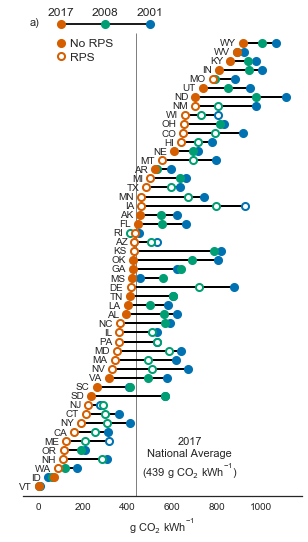

In [133]:
states_index = list(barbell_index.index)

dumbell_plot(barbell_index, [2001, 2008, 2017], states_index, 
             legend_loc=[500, 300, 100], rps_legend=True,
             rps_start=rps_start, palette='colorblind')

plt.vlines(439, -1, 50, colors=['0.5'], zorder=1, #linestyles='dashed',
           linewidth=1)

plt.ylim(-1, 53)
# plt.text(x=200, y=40, s='2017\nNational Average\n(439 g CO$_2$ $\mathregular{kWh^{-1}}$)',
#          ha='center', va='center', size=11)
plt.text(x=680, y=3, s='2017\nNational Average\n(439 g CO$_2$ $\mathregular{kWh^{-1}}$)',
         ha='center', va='center', size=11)
sns.despine(left=True)
plt.xlabel('g CO$_2$ $\mathregular{kWh^{-1}}$')

# label as part of a larger figure
plt.text(-0.02, 0.89, s='a)', ha='right', size=11, transform=ax.transAxes)

path = join(cwd, '..', 'Figures',
            'State CO2 intensity {}.pdf'.format(file_date))
plt.savefig(path, bbox_inches='tight')

In [43]:
barbell_index.loc['USA', 2001] = 630
barbell_index.loc['USA', 2008] = 580
barbell_index.loc['USA', 2017] = 439
barbell_index.sort_values(by=[2017], inplace=True)

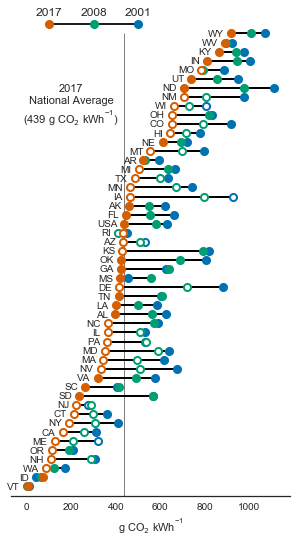

In [44]:
states_index = list(barbell_index.index)

dumbell_plot(barbell_index, [2001, 2008, 2017], states_index, 
             legend_loc=[500, 300, 100],
             rps_start=rps_start, palette='colorblind')

plt.vlines(439, -1, 50, colors=['0.5'], zorder=1, #linestyles='dashed',
           linewidth=1)

plt.ylim(-1, 53)
plt.text(x=200, y=40, s='2017\nNational Average\n(439 g CO$_2$ $\mathregular{kWh^{-1}}$)',
         ha='center', size=11)
sns.despine(left=True)
plt.xlabel('g CO$_2$ $\mathregular{kWh^{-1}}$')
path = join(cwd, '..', 'Figures',
            'State CO2 intensity {}.pdf'.format('David Hawkins'))
plt.savefig(path, bbox_inches='tight')

## Largest and smallest changes

In [15]:
barbell_index['change'] = barbell_index[2017] - barbell_index[2001]
barbell_index['% change'] = barbell_index['change'] / barbell_index[2001]

In [16]:
max_change_state = barbell_index.sort_values('change').index[0]
max_change_value = barbell_index.sort_values('change')['change'].values[0]
start = barbell_index.loc[max_change_state, 2001]
end = barbell_index.loc[max_change_state, 2017]
print('The largest absolute reduction is {:0.1f} g/kWh in {}, from {:.1f} to {:.1f}'
      .format(max_change_value, max_change_state, start, end))

The largest absolute reduction is -466.4 g/kWh in DE, from 880.0 to 413.7


In [17]:
min_change_state = barbell_index.sort_values('change').index[-1]
min_change_value = barbell_index.sort_values('change')['change'].values[-1]
start = barbell_index.loc[min_change_state, 2001]
end = barbell_index.loc[min_change_state, 2017]
print('The smallest absolute reduction is {:0.1f} g/kWh in {}, from {:.1f} to {:.1f}'
      .format(min_change_value, min_change_state, start, end))

The smallest absolute reduction is 30.5 g/kWh in ID, from 41.2 to 71.7


In [18]:
max_relchange_state = barbell_index.sort_values('% change').index[0]
max_relchange_value = barbell_index.sort_values('% change')['% change'].values[0]
start = barbell_index.loc[max_relchange_state, 2001]
end = barbell_index.loc[max_relchange_state, 2017]
print('The largest relative reduction is {:0.1%} g/kWh in {}, from {:.1f} to {:.1f}'
      .format(max_relchange_value, max_relchange_state, start, end))

The largest relative reduction is -64.6% g/kWh in NH, from 307.4 to 108.9


In [19]:
min_relchange_state = barbell_index.sort_values('% change').index[-1]
min_relchange_value = barbell_index.sort_values('% change')['% change'].values[-1]
start = barbell_index.loc[min_relchange_state, 2001]
end = barbell_index.loc[min_relchange_state, 2017]
print('The smallest relative reduction is {:0.1%} g/kWh in {}, from {:.1f} to {:.1f}'
      .format(min_relchange_value, min_relchange_state, start, end))

The smallest relative reduction is 74.0% g/kWh in ID, from 41.2 to 71.7


## Population

In [45]:
path = os.path.join(base_path, 'Data storage', 'Derived data',
                    'State population.csv')
pop = pd.read_csv(path)
pop.columns = pop.columns.str.lower()

In [46]:
pop.head()

,state,year,population
0,United States,2000,282162411
1,Alabama,2000,4452173
2,Alaska,2000,627963
3,Arizona,2000,5160586
4,Arkansas,2000,2678588


In [47]:
pop.tail()

,state,year,population
930,Virginia,2017,8470020
931,Washington,2017,7405743
932,West Virginia,2017,1815857
933,Wisconsin,2017,5795483
934,Wyoming,2017,579315


In [48]:
pop['state'] = pop['state'].map(us_state_abbrev)

In [49]:
pop.head()

,state,year,population
0,US,2000,282162411
1,AL,2000,4452173
2,AK,2000,627963
3,AZ,2000,5160586
4,AR,2000,2678588


In [50]:
annual_index_pop = annual_index.reset_index().merge(pop, on=['state', 'year'])

In [51]:
annual_index_pop.head()

,state,year,final co2 (kg),generation (mwh),index (g/kwh),population
0,AK,2001,4.192039e+09,6743766.00,621.616856,633714
1,AK,2002,3.829402e+09,6767322.00,565.866731,642337
2,AK,2003,3.474714e+09,6338738.00,548.171264,648414
3,AK,2004,3.492109e+09,6526716.92,535.048356,659286
4,AK,2005,3.531411e+09,6576658.54,536.961208,666946


In [52]:
annual_index_pop['tonne CO2/pop'] = (annual_index_pop['final co2 (kg)']
                                         / 1000
                                         / annual_index_pop['population'])
annual_index_pop['MWh/pop'] = (annual_index_pop.loc[:, 'generation (mwh)']
                                         / annual_index_pop['population'])

In [53]:
annual_index_pop.describe(percentiles=[.1, .25])

,year,final co2 (kg),generation (mwh),index (g/kwh),population,tonne CO2/pop,MWh/pop
count,850.000000,8.500000e+02,8.500000e+02,850.000000,8.500000e+02,850.000000,850.000000
mean,2009.000000,4.425946e+10,8.056302e+07,547.438394,6.106634e+06,10.669395,16.792258
std,4.901864,4.218201e+10,7.348272e+07,246.740510,6.752970e+06,13.539141,13.050768
min,2001.000000,4.732677e+06,1.986881e+06,0.996470,4.946570e+05,0.007559,3.181076
10%,2002.000000,3.530592e+09,1.043385e+07,209.386261,8.451272e+05,1.904900,7.319306
25%,2005.000000,1.461421e+10,3.364504e+07,402.071114,1.802464e+06,3.828428,9.933583
50%,2009.000000,3.529086e+10,5.773346e+07,547.382227,4.363600e+06,7.615839,14.472842
max,2017.000000,2.486620e+11,4.544390e+08,1111.411905,3.953665e+07,96.738933,90.521185


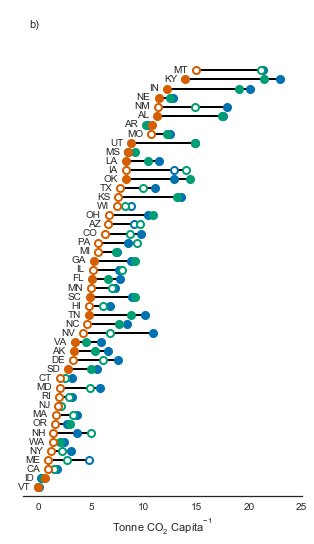

In [101]:
barbell_pop = annual_index_pop.pivot_table(values='tonne CO2/pop',
                                              index='state', columns='year')
barbell_pop.sort_values(by=2017, inplace=True)
barbell_pop.drop(['WY', 'ND', 'WV'], inplace=True)

# states_pop = ['{}  '.format(x) for x in barbell_pop.index]
states_pop = list(barbell_pop.index)
# rps_states = list(rps_tidy['state'].unique())

dumbell_plot(barbell_pop, [2001, 2008, 2017], states_pop, offset_divider=30,
             rps_start=rps_start, legend=False, palette='colorblind')

plt.ylim(-1, 53)
plt.xlim(None, 25)

sns.despine(left=True)
plt.xlabel('Tonne $\mathregular{CO_2 \ Capita^{-1}}$')

# label as part of a larger figure
plt.text(-0.02, 0.89, s='b)', ha='right', size=11, transform=ax.transAxes)

path = join(fig_export_path,
            'State CO2 per capita {}.pdf'.format(file_date))
plt.savefig(path, bbox_inches='tight')

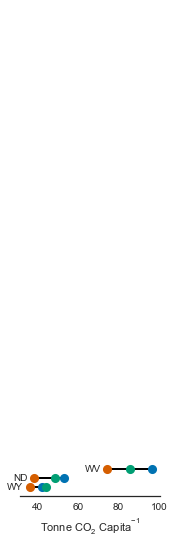

In [77]:
barbell_pop = annual_index_pop.pivot_table(values='tonne CO2/pop',
                                           index='state', columns='year')
barbell_pop.sort_values(by=2017, inplace=True)
barbell_pop = barbell_pop.loc[['WV', 'ND', 'WY']]

states_pop = ['WY', 'ND', 'WV']
# rps_states = list(rps_tidy['state'].unique())

dumbell_plot(barbell_pop, [2001, 2008, 2017], states_pop, offset_divider=30,
             rps_start=rps_start, legend=False, palette='colorblind',
             figsize=(2.5, 9))

plt.ylim(-1, 53)
# plt.xlim(None, 25)

sns.despine(left=True)
plt.xlabel('Tonne $\mathregular{CO_2 \ Capita^{-1}}$')
path = join(fig_export_path,
            'State CO2 per capita insert {}.pdf'.format(file_date))
plt.savefig(path, bbox_inches='tight')

## State electricity imports/exports
Data is from [EIA State Energy Data System](https://www.eia.gov/state/seds/seds-data-complete.php?sid=US#Consumption). Most recent update was March 9, 2018. Code are described in [EIA documentation](https://www.eia.gov/state/seds/sep_use/notes/use_a.pdf). Negative values indicate flows out of the state.

In [31]:
path = os.path.join(base_path, 'Data storage', 'State energy flows',
                    'use_all_phy_update.csv')
flows = pd.read_csv(path)

# ELISP is electricity flows
flows = flows.loc[flows['MSN'] == 'ELISP']

# Drop all years before 2001
flows.drop([str(x) for x in range(1960, 2001)], axis=1, inplace=True)
flows.drop(['Data_Status', 'MSN'], axis=1, inplace=True)

# Electricity flows are given in million kWh (see documentation)
flows.loc[:, '2001':] *= 1000

flows.columns = flows.columns.str.lower()

In [32]:
flows = flows.melt(id_vars='state', var_name='year',
                   value_name='MWh flow')
flows['year'] = flows['year'].astype(int)

In [33]:
flows.tail()

,state,year,MWh flow
827,VT,2016,NaN
828,WA,2016,NaN
829,WI,2016,NaN
830,WV,2016,NaN
831,WY,2016,NaN


In [34]:
annual_index_pop_flows = pd.merge(annual_index_pop, flows, on=['state', 'year'])
annual_index_pop_flows['MWh flow/pop'] = (annual_index_pop_flows['MWh flow']
                                          / annual_index_pop_flows['population'])
annual_index_pop_flows['share flow'] = (annual_index_pop_flows['MWh/pop']
                                          / annual_index_pop_flows['MWh flow/pop'])

In [35]:
annual_index_pop_flows.tail()

,state,year,final co2 (kg),generation (mwh),index (g/kwh),population,tonne CO2/pop,MWh/pop,MWh flow,MWh flow/pop,share flow
795,WY,2012,4.610672e+10,49588606.28,929.784645,576765,79.940226,85.977142,-30130000.0,-52.239647,-1.645822
796,WY,2013,4.886832e+10,52483065.48,931.125515,582684,83.867622,90.071232,-32933000.0,-56.519486,-1.593631
797,WY,2014,4.506333e+10,49698557.94,906.733105,583642,77.210564,85.152470,-30055000.0,-51.495609,-1.653587
798,WY,2015,4.567480e+10,48968928.92,932.730320,586555,77.869603,83.485656,-29420000.0,-50.157274,-1.664478
799,WY,2016,4.273486e+10,46660041.39,915.877066,585501,72.988538,79.692505,NaN,NaN,NaN


In [36]:
barbell_flows = annual_index_pop_flows.pivot_table(values='MWh flow/pop',
                                              index='state', columns='year')

barbell_flows.head()

year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
state,,,,,,,,,,,,,,,
AK,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AL,-7.835467,-8.475724,-9.253044,-8.264674,-8.455503,-8.083637,-8.581933,-9.436638,-10.417118,-10.419200,-11.692700,-11.484522,-10.776732,-9.903135,-10.978857
AR,-0.247439,0.073173,-0.761886,-0.933197,1.385065,-0.031895,-0.638197,-1.173747,-3.186918,-2.553735,-2.774628,-4.354582,-2.836078,-3.210409,-1.663951
AZ,-4.479208,-5.011809,-4.669383,-5.711906,-4.520920,-4.207233,-4.789482,-5.827053,-5.143813,-5.216974,-4.345491,-4.611250,-4.863526,-4.590332,-4.481365
CA,2.190000,2.310202,2.196115,2.535800,2.199931,2.135548,2.150713,2.447797,2.196166,2.134108,2.210720,2.126722,2.066795,2.060944,2.035342


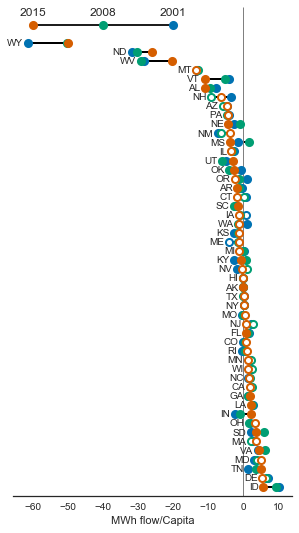

In [37]:
barbell_flows = annual_index_pop_flows.pivot_table(values='MWh flow/pop',
                                              index='state', columns='year')
barbell_flows.sort_values(by=2015, ascending=False, inplace=True)
# barbell_flows.drop('VT', inplace=True)

states_flows = list(barbell_flows.index)

dumbell_plot(barbell_flows, [2001, 2008, 2015], states_flows, offset_divider=8,
             rps_start=rps_start, legend=True, palette='colorblind',
             legend_loc=[-20, -40, -60])

plt.ylim(-1, 53)
sns.despine(left=True)
plt.xlabel('MWh flow/Capita')
plt.vlines(0, -1, 53, colors=['0.5'], linewidth=1)
# plt.xticks()
# ax = plt.gca()
# ax.set_xscale("log", nonposx='clip')
path = join(fig_export_path, 'SI', 'State MWh flow per capita.pdf')
# plt.savefig(path, bbox_inches='tight')